<a href="https://colab.research.google.com/github/AshuMaths1729/COVID_jobs/blob/main/AFRIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 
import math
import numpy as np
import pandas as pd
 
import statsmodels.tsa.stattools as st
 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
 
#plotting libraries
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
 
import seaborn as sns
 
#Initialize figure size (in inches)
plt.rcParams['figure.figsize'] = [10,5]
 
#pd.options.display.max_rows = 10
#pd.options.display.float_format = '{:.1f}'.format
 
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
 
"""Computes the weights for our fractionally differenced features up to a given threshold
   requirement for fixed-window fractional differencing. 
    Args:
        d: A float representing the differencing factor
        length: An int length of series to be differenced
        threshold: A float representing the minimum threshold to include weights for
    Returns:
        A numpy array containing the weights to be applied to our time series
"""
def findWeights_FFD(d, length, threshold):
    #set first weight to be 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    
    #while we still have more weights to process, do the following:
    while(k < length):
        
        w_curr = (-w[-1]*(d-k+1))/k
        
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            
            break
            
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        
        #increment k
        k += 1
        
    #make sure to convert it into a numpy array and reshape from a single row to a single
    #column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

In [ ]:
"""Computes fractionally differenced series 
    Args:
        d: A float representing the differencing factor (any positive fractional)
        series: A pandas dataframe with one or more columns of time-series values to be differenced
        threshold: Threshold value past which we ignore weights 
            (cutoff weight for window)
    Returns: 
        diff_series: A numpy array of differenced series by d. 
"""
def fracDiff(series, d, threshold = 1e-5):
    #compute weights using function above
    weights = findWeights_FFD(d, len(series), threshold)
    width = len(weights) - 1
    
    df = {}
    #for each series to be differenced, apply weights to appropriate prices and save 
    for name in series.columns:
        
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series()
        
        #loop through all values that fall into range to be fractionally differenced
        for iloc1 in range(width, curr_series.shape[0]):
            
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp[loc1]= np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/COVID_Jobs/Data/Monthly_Unemployment_1991-2020.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df['ds']=pd.to_datetime(df['ds'])

In [ ]:
df.set_index('ds',inplace=True)

In [ ]:
df.head()

,y
ds,
1991-12-31,5.450000
1992-01-31,5.454167
1992-02-29,5.458333
1992-03-31,5.462500
1992-04-30,5.466667


In [ ]:
df[['y']]

,y
ds,
1991-12-31,5.450000
1992-01-31,5.454167
1992-02-29,5.458333
1992-03-31,5.462500
1992-04-30,5.466667
...,...
2020-07-31,7.430000
2020-08-31,8.350000
2020-09-30,6.670000


In [ ]:
test_series = df[['y']]
fracDiff(test_series, 0.1, 1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,y
1997-01-31,3.507789
1997-02-28,3.506590
1997-03-31,3.505475
1997-04-30,3.504416
1997-05-31,3.503399
...,...
2020-07-31,3.147793
2020-08-31,4.655877
2020-09-30,3.140790
2020-10-31,3.723933


In [ ]:
 
test_series = df[['y']]
 
df_result = fracDiff(test_series, 0.1, 1e-3)
 
df_result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,y
1997-01-31,3.507789
1997-02-28,3.506590
1997-03-31,3.505475
1997-04-30,3.504416
1997-05-31,3.503399
...,...
2020-07-31,3.147793
2020-08-31,4.655877
2020-09-30,3.140790
2020-10-31,3.723933


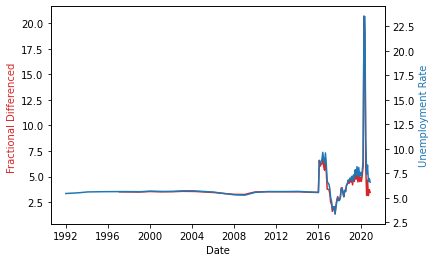

In [ ]:
fig, ax1 = plt.subplots()
 
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Fractional Differenced ', color=color)
ax1.plot( df_result['y'], color=color)
 
ax2 = ax1.twinx()
 
color = 'tab:blue'
ax2.set_ylabel('Unemployment Rate', color = color)
ax2.plot(df['y'], color=color)
 
plt.show()